In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import random
import keras
import os, glob
import librosa, librosa.display

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D
from keras.models import Sequential, model_from_json
from keras import backend as K

from imblearn.over_sampling import RandomOverSampler


In [3]:
tf.__version__

'1.14.0'

In [4]:
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
K.tensorflow_backend._get_available_gpus()

[]

In [6]:
from settings import *

In [526]:
len(glob.glob(DATA_DIR_GUITAR + "**/*.wav"))

2000

### Generate Metadata

In [5]:
def df_info(f):
    def inner(df, *args, **kwargs):
        result = f(df, *args, **kwargs)
        print(f"After applying {f.__name__}, shape of df = {result.shape }")
        print(f"Columns of df are {df.columns}\n")
        return result
    return inner

# Construct Dataframe with all required values
@df_info
def construct_dataframe(df):
    df['file_path'] = file_path
    df['file_path'] = df['file_path'].map(lambda x: x[x.rindex('Only/')+len('Only/'):])
    df['file_name'] = df['file_path'].map(lambda x: x[x.rindex('/')+1:])
    df['class_name'] = df['file_path'].map(lambda x: x[:x.index('/')])
    df['class_ID'] = df['class_name'].map(lambda x: CLASSES_MAP[x])
    return df.copy()

# Extract spectrogram from audio
@df_info
def get_spectrogram(df):
    df['audio_series'] = df['file_path'].map(lambda x: librosa.load(DATA_DIR_GUITAR + x, duration=2))
    df['y'] = df['audio_series'].map(lambda x: x[0])
    df['sr'] = df['audio_series'].map(lambda x: x[1])
    df['spectrogram'] = df.apply(lambda row: librosa.feature.melspectrogram(y=row['y'], sr=row['sr']), axis=1)
    df.drop(columns='audio_series', inplace=True)
    return df

@df_info
def get_count(df):
    return df['class_name'].value_counts()

@df_info
def add_shape(df):
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    return df

### Generate raw data

In [159]:
file_path = glob.glob(DATA_DIR_GUITAR + "**/*.wav")
data_df_raw = (pd.DataFrame().pipe(construct_dataframe)
                            .pipe(get_spectrogram)
                             .pipe(add_shape)
            )


After applying construct_dataframe, shape of df = (2000, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID'], dtype='object')

After applying get_spectrogram, shape of df = (2000, 7)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram'],
      dtype='object')



In [126]:
get_count(data_df_raw)

After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram'],
      dtype='object')



dm    200
e     200
bm    200
am    200
d     200
a     200
em    200
f     200
g     200
c     200
Name: class_name, dtype: int64

### Save raw data


- csv just for human readable format
- pkl is actually used since it can store numpy arrays

In [275]:
data_df_raw.to_csv(os.path.join(METADATA_DIR_RAW, 'data.csv'), index=False)
data_df_raw.to_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

In [ ]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

In [158]:
data_df_raw.head()

,file_path,file_name,class_name,class_ID,y,sr,spectrogram
0,g/g102.wav,g102.wav,g,9,[-0.0703664 -0.10625491 -0.06439576 ... -0.02...,22050,[[9.56414733e-03 2.09606037e-01 1.36905205e+00...
1,g/g194.wav,g194.wav,g,9,[ 0.00393952 0.00571453 0.00609498 ... -0.00...,22050,[[9.17346403e-03 9.72308777e-03 5.16915461e-03...
2,g/g144.wav,g144.wav,g,9,[-0.00017986 0.00102038 0.00373939 ... -0.00...,22050,[[2.3263648e-02 1.3200079e-02 5.6901169e-03 .....
3,g/g160.wav,g160.wav,g,9,[-0.00084703 -0.00043425 -0.00062728 ... 0.00...,22050,[[3.0921197e-03 8.7422887e-03 1.7377490e-02 .....
4,g/g129.wav,g129.wav,g,9,[-0.00644014 -0.00737232 -0.00073748 ... 0.00...,22050,[[1.17112761e-02 8.50785989e-03 6.17251592e-03...


### Process and save processed data

- csv just for human readable format
- pkl is actually used since it can store numpy arrays

In [7]:
# Maintain same shape
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process(df):
    df = (df.pipe(clean_shape)
                .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name']]
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df['spectrogram'].values, df['class_ID'].values
    X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df

def get_class(class_ID):
    return list(CLASSES_MAP.keys())[list(CLASSES_MAP.values()).index(class_ID)]

In [498]:
data_df_processed = process(data_df_raw)

The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (633, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')

After applying over_sample, shape of df = (1150, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')

After applying process, shape of df = (1150, 3)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')



In [499]:
get_count(data_df_processed)

After applying get_count, shape of df = (10,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name'], dtype='object')



dm    115
e     115
bm    115
am    115
g     115
d     115
a     115
em    115
c     115
f     115
Name: class_name, dtype: int64

In [500]:
data_df_processed.to_csv(os.path.join(METADATA_DIR_PROCESSED, 'data.csv'), index=False)
data_df_processed.to_pickle(os.path.join(METADATA_DIR_PROCESSED, 'data.pkl'))

In [501]:
data_df_processed.head()

,spectrogram,class_ID,class_name
0,"[[0.023263648, 0.013200079, 0.005690117, 0.005...",9,g
1,"[[0.0030921197, 0.008742289, 0.01737749, 0.010...",9,g
2,"[[0.011711276, 0.00850786, 0.006172516, 0.0059...",9,g
3,"[[0.008072537, 0.006353717, 0.0074853124, 0.00...",9,g
4,"[[0.0064443834, 0.007321003, 0.0068667047, 0.0...",9,g


### Examples of Siren spectrograms

In [30]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[0],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr)
ps.shape

(128, 76)

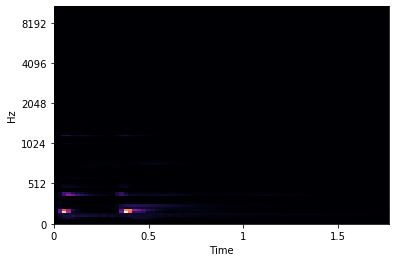

In [31]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [33]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[201],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


(128, 81)

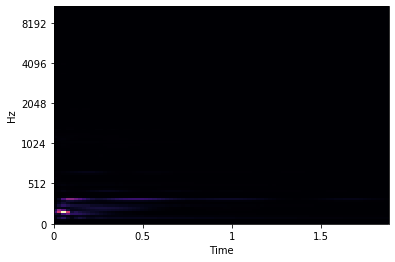

In [34]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [35]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[401],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


(128, 87)

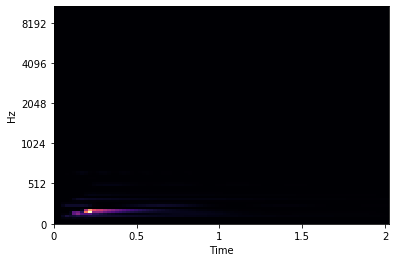

In [36]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

In [37]:
y, sr = librosa.load(DATA_DIR_GUITAR+data_df_raw['file_path'].iloc[801],duration=2)
ps = librosa.feature.melspectrogram(y=y, sr=sr,)
ps.shape


(128, 68)

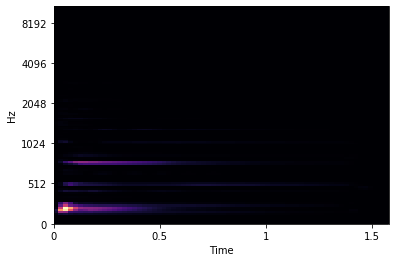

In [38]:
librosa.display.specshow(ps, y_axis='mel', x_axis='time')

## Training

### Load processed data

In [503]:
dataset = pd.read_pickle(os.path.join(METADATA_DIR_PROCESSED, 'data.pkl'))

In [504]:
print("Number of samples: ", len(dataset))

Number of samples:  1150


In [505]:
dataset.iloc[0]

spectrogram    [[0.023263648, 0.013200079, 0.005690117, 0.005...
class_ID                                                       9
class_name                                                     g
Name: 0, dtype: object

In [506]:
dataset['spectrogram'].iloc[0].shape

(128, 87)

### Splitting into train and test

In [507]:
np.random.seed(42)
sample = np.random.choice(dataset.index, size=int(len(dataset)*0.8), replace=False)
train_data, test_data = dataset.iloc[sample], dataset.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 920
Number of testing samples is 230
                                           spectrogram  class_ID class_name
174  [[0.046818838, 0.026844991, 0.009680895, 0.007...         1         am
752  [[0.0006190296, 0.00059949054, 0.00044531212, ...         2         bm
467  [[0.007340345, 0.005847832, 0.006782163, 0.004...         6          e
240  [[0.48427373, 0.11414378, 0.0058219954, 0.0058...         3          c
667  [[0.0030681787, 0.004598457, 0.0036218201, 0.0...         0          a
218  [[0.0074670273, 0.0066150953, 0.0060418868, 0....         3          c
867  [[0.00015142752, 0.00018522875, 9.559582e-05, ...         4          d
420  [[7.87276e-05, 7.189855e-05, 0.00018623109, 0....         2         bm
351  [[0.00012273485, 0.00016972361, 0.00024977553,...         8          f
328  [[0.000764267, 0.0005248326, 0.00036606504, 0....         5         dm
                                          spectrogram  class_ID class_name
1   [[0.0030921197, 0.

In [508]:
train_data['spectrogram'].iloc[0]

array([[4.6818838e-02, 2.6844991e-02, 9.6808951e-03, ..., 6.1833183e-03,
        7.4705025e-03, 2.4528878e-02],
       [8.1299953e-03, 5.3190491e-03, 5.0602490e-03, ..., 5.8139743e-05,
        1.9048223e-03, 1.1817389e-02],
       [4.0778562e-01, 9.2032832e-01, 1.5335680e+00, ..., 4.9403263e-04,
        7.3649571e-03, 3.9279733e-02],
       ...,
       [3.2432359e-02, 3.7415069e-02, 2.2326944e-02, ..., 3.6768961e-06,
        6.3032171e-06, 1.4038159e-05],
       [1.4877983e-02, 1.8892338e-02, 1.2256243e-02, ..., 1.8769103e-06,
        2.4040874e-06, 6.7680508e-06],
       [1.0006273e-03, 6.5019802e-04, 3.1044008e-04, ..., 1.7233739e-07,
        5.9962952e-07, 2.7855019e-06]], dtype=float32)

In [509]:
print(train_data.iloc[0])
print(train_data.iloc[0][0].shape)   #shape of input image
print(train_data.iloc[0][0][0][1])
print(train_data.iloc[0][1])    #output class id

spectrogram    [[0.046818838, 0.026844991, 0.009680895, 0.007...
class_ID                                                       1
class_name                                                    am
Name: 174, dtype: object
(128, 87)
0.026844991
1


## Splitting the data into features (X) and targets (y)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [510]:
X_train = train_data['spectrogram']
y_train = train_data['class_ID']
X_test = test_data['spectrogram']
y_test = test_data['class_ID']

print(X_train[:10])
print(y_train[:10])

174    [[0.046818838, 0.026844991, 0.009680895, 0.007...
752    [[0.0006190296, 0.00059949054, 0.00044531212, ...
467    [[0.007340345, 0.005847832, 0.006782163, 0.004...
240    [[0.48427373, 0.11414378, 0.0058219954, 0.0058...
667    [[0.0030681787, 0.004598457, 0.0036218201, 0.0...
218    [[0.0074670273, 0.0066150953, 0.0060418868, 0....
867    [[0.00015142752, 0.00018522875, 9.559582e-05, ...
420    [[7.87276e-05, 7.189855e-05, 0.00018623109, 0....
351    [[0.00012273485, 0.00016972361, 0.00024977553,...
328    [[0.000764267, 0.0005248326, 0.00036606504, 0....
Name: spectrogram, dtype: object
174    1
752    2
467    6
240    3
667    0
218    3
867    4
420    2
351    8
328    5
Name: class_ID, dtype: int64


### Reshape for CNN input

In [511]:
X_train = np.array([x.reshape( (128, 87, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 87, 1) ) for x in X_test])

In [512]:
print(X_train[0].shape)
print(y_train[0])

(128, 87, 1)
9


### One-Hot encoding for classes

In [513]:
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [514]:
print(y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


### Model

In [515]:
model = Sequential()
input_shape=(128, 87, 1)

model.add(Conv2D(24, (5, 5), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(MaxPooling2D((4, 2), strides=(4, 2)))
model.add(Activation('relu'))

model.add(Conv2D(48, (5, 5), padding="valid"))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

In [516]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 124, 83, 24)       624       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 41, 24)        0         
_________________________________________________________________
activation_11 (Activation)   (None, 31, 41, 24)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 27, 37, 48)        28848     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 18, 48)         0         
_________________________________________________________________
activation_12 (Activation)   (None, 6, 18, 48)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 2, 14, 48)        

In [517]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

In [518]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=70,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Train on 920 samples, validate on 230 samples
Epoch 1/70
920/920 [==============================] - 4s 4ms/step - loss: 2.3751 - accuracy: 0.1174 - precision: 0.2326 - recall: 0.0217 - fmeasure: 0.0389 - val_loss: 2.1969 - val_accuracy: 0.1261 - val_precision: 0.0417 - val_recall: 0.0042 - val_fmeasure: 0.0076
Epoch 2/70
920/920 [==============================] - 3s 3ms/step - loss: 2.2245 - accuracy: 0.1576 - precision: 0.2319 - recall: 0.0185 - fmeasure: 0.0335 - val_loss: 2.1098 - val_accuracy: 0.2087 - val_precision: 0.3333 - val_recall: 0.0208 - val_fmeasure: 0.0390
Epoch 3/70
920/920 [==============================] - 3s 3ms/step - loss: 2.2010 - accuracy: 0.1793 - precision: 0.2446 - recall: 0.0207 - fmeasure: 0.0374 - val_loss: 2.0489 - val_accuracy: 0.2652 - val_precision: 0.1250 - val_recall: 0.0125 - val_fmeasure: 0.0227
Epoch 4/70
920/920 [==============================] - 3s 3ms/step - loss: 2.0950 - accuracy: 0.2130 - precision: 0.4652 - recall: 0.0500 - fmeasure: 0.0889 

Epoch 62/70
920/920 [==============================] - 3s 3ms/step - loss: 0.2494 - accuracy: 0.9196 - precision: 0.9356 - recall: 0.9011 - fmeasure: 0.9177 - val_loss: 0.1794 - val_accuracy: 0.9217 - val_precision: 0.9331 - val_recall: 0.9250 - val_fmeasure: 0.9290
Epoch 63/70
920/920 [==============================] - 3s 3ms/step - loss: 0.2562 - accuracy: 0.9000 - precision: 0.9172 - recall: 0.8815 - fmeasure: 0.8987 - val_loss: 0.3966 - val_accuracy: 0.9174 - val_precision: 0.9285 - val_recall: 0.9167 - val_fmeasure: 0.9224
Epoch 64/70
920/920 [==============================] - 3s 3ms/step - loss: 0.2310 - accuracy: 0.9163 - precision: 0.9320 - recall: 0.9022 - fmeasure: 0.9163 - val_loss: 0.2894 - val_accuracy: 0.9348 - val_precision: 0.9489 - val_recall: 0.9292 - val_fmeasure: 0.9387
Epoch 65/70
920/920 [==============================] - 3s 3ms/step - loss: 0.2286 - accuracy: 0.9239 - precision: 0.9392 - recall: 0.9098 - fmeasure: 0.9239 - val_loss: 0.2054 - val_accuracy: 0.9304 

In [521]:
y_test_values.shape

(230,)

In [522]:
predictions = model.predict_classes(X_test)

In [523]:
conf_mat=confusion_matrix(y_test_values, predictions, labels=range(10))
conf_mat

array([[20,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 18,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 27,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 26,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  1, 17,  5,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 22,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 37,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 21]])

### Save model to disk

### serialize model to JSON

In [524]:
model_json = model.to_json()
with open(MODEL_JSON, "w") as json_file:
    json_file.write(model_json)

### serialize weights to HDF5

In [525]:
model.save_weights(MODEL_H5)
print("Saved model to disk")

Saved model to disk


## Data Augmentation

In [1]:
def get_augmentation_count(df):
    return df['augmentation'].value_counts()

In [219]:
data_df_raw = pd.read_pickle(os.path.join(METADATA_DIR_RAW, 'data.pkl'))

### 1. Vary Time

In [ ]:
data_df_time_inc = augment_data(data_df_raw.copy(), kind='time', rate=1.07)
                    

data_df_time_dec = augment_data(data_df_raw.copy(), kind='time', rate=0.81)

### 2. Vary pitch

In [239]:
data_df_shift_20 = augment_data(data_df_raw.copy(), kind='pitch', rate=2.5)

data_df_shift_25 = augment_data(data_df_raw.copy(), kind='pitch', rate=2)

After applying augment_data, shape of df = (4000, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')

After applying augment_data, shape of df = (4000, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')



### Create Augmented Metada

In [264]:
data_df_raw['augmentation'] = 'None'
data_df_augmented_raw = pd.concat([data_df_raw, data_df_time_inc, data_df_time_dec, data_df_shift_20, data_df_shift_25], axis=0)

In [284]:
data_df_augmented_raw = data_df_augmented_raw.pipe(add_shape)

After applying add_shape, shape of df = (16000, 9)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')



In [312]:
print(get_augmentation_count(data_df_augmented_raw))

After applying get_augmentation_count, shape of df = (5,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')

None         8000
pitch_250    2000
pitch_200    2000
speed_81     2000
speed_107    2000
Name: augmentation, dtype: int64


In [286]:
print(get_count(data_df_augmented_raw))

After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')

e     1600
d     1600
a     1600
g     1600
am    1600
c     1600
bm    1600
f     1600
dm    1600
em    1600
Name: class_name, dtype: int64


In [282]:
data_df_augmented_raw.head()

,file_path,file_name,class_name,class_ID,y,sr,spectrogram,augmentation,shape
0,g/speed_107/g102.wav,g102.wav,g,9,"[-0.07182093, -0.10744891, -0.06559521, -0.086...",22050,"[[0.009544356, 0.18455605, 1.1824054, 0.513804...",speed_107,"(128, 71)"
1,g/speed_107/g194.wav,g194.wav,g,9,"[0.0042471434, 0.0057702884, 0.005924746, 0.00...",22050,"[[0.0091888, 0.0096358005, 0.0052495273, 0.006...",speed_107,"(128, 72)"
2,g/speed_107/g144.wav,g144.wav,g,9,"[-1.4150559e-05, 0.0011950773, 0.0038850766, 0...",22050,"[[0.02301405, 0.013076712, 0.005735046, 0.0057...",speed_107,"(128, 81)"
3,g/speed_107/g160.wav,g160.wav,g,9,"[-0.00116409, -0.00061268755, -0.00042036132, ...",22050,"[[0.0030068015, 0.008565176, 0.016034044, 0.00...",speed_107,"(128, 81)"
4,g/speed_107/g129.wav,g129.wav,g,9,"[-0.005619276, -0.006499503, 0.00010849091, 0....",22050,"[[0.011926388, 0.008582427, 0.0061589293, 0.00...",speed_107,"(128, 81)"


### Save augmented raw data

In [268]:
data_df_augmented_raw.to_csv(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.csv'), index=False)


After applying get_count, shape of df = (10,)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation'],
      dtype='object')

e     1600
d     1600
a     1600
g     1600
am    1600
c     1600
bm    1600
f     1600
dm    1600
em    1600
Name: class_name, dtype: int64


### Process and save processed augmented data

In [10]:
data_df_augmented_raw = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_RAW, 'data.pkl'))

In [13]:
# Maintain same shape
@df_info
def clean_shape(df):
    max_shape = df['spectrogram'].map(lambda x: x.shape).value_counts().index[0]
    print(f"The most frequent shape is {max_shape}")
    df['shape'] = df['spectrogram'].map(lambda x: x.shape)
    df = df[df['shape']==max_shape]
    df.drop(columns='shape', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

@df_info
def process_augmented(df):
    df = (df.pipe(clean_shape)
            .pipe(over_sample)
    )
    df = df[['spectrogram','class_ID', 'class_name', 'augmentation']]
    
    return df

#Over sampling data
@df_info
def over_sample(df):
    oversample = RandomOverSampler(sampling_strategy='auto')
    X, y = df[['spectrogram', 'augmentation']].values, df['class_ID'].values
#     X = X.reshape(-1, 1)
    X, y = oversample.fit_resample(X, y)
    df = pd.DataFrame()
    df['spectrogram'] = pd.Series([np.array(x[0]) for x in X])
    df['augmentation'] = pd.Series([np.array(x[1]) for x in X])
    df['augmentation'] = df['augmentation'].map(lambda x: str(x))
    df['class_ID'] = pd.Series(y)
    df['class_name'] = df['class_ID'].map(lambda x: get_class(x))
    return df

In [12]:
data_df_augmented_processed = process_augmented(data_df_augmented_raw)

In [288]:
data_df_augmented_processed.to_csv(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.csv'), index=False)
data_df_augmented_processed.to_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))

The most frequent shape is (128, 87)
After applying clean_shape, shape of df = (3830, 8)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')

After applying process_augmented, shape of df = (3830, 4)
Columns of df are Index(['file_path', 'file_name', 'class_name', 'class_ID', 'y', 'sr',
       'spectrogram', 'augmentation', 'shape'],
      dtype='object')



In [290]:
print(get_count(data_df_augmented_processed))

After applying get_count, shape of df = (10,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name', 'augmentation'], dtype='object')

c     691
am    578
e     558
g     531
d     524
dm    279
em    275
a     185
f     173
bm     36
Name: class_name, dtype: int64


In [296]:
print(get_augmentation_count(data_df_augmented_processed))

After applying get_augmentation_count, shape of df = (4,)
Columns of df are Index(['spectrogram', 'class_ID', 'class_name', 'augmentation'], dtype='object')

None         2532
pitch_200     633
pitch_250     633
speed_81       32
Name: augmentation, dtype: int64


The dataset consists of:
- 1-633 normal samples.
- 634-981 samples speed up by 1.07.
- 982-2594 samples Slowed down to 0.81.
- 2595-3227 samples Pitch modulated 2 semitones higher.
- 3228-3860 samples Pitch modulated 2.5 semitones higher.





### Load processed augmented data

In [291]:
dataset = pd.read_pickle(os.path.join(METADATA_DIR_AUGMENTED_PROCESSED, 'data.pkl'))

In [292]:
print("Number of samples: ", len(dataset))

Number of samples:  3830


In [293]:
dataset.iloc[0]

spectrogram     [[0.023263648, 0.013200079, 0.005690117, 0.005...
class_ID                                                        9
class_name                                                      g
augmentation                                                 None
Name: 0, dtype: object

In [294]:
dataset['spectrogram'].iloc[0].shape

(128, 87)

### Splitting into train and test

In [295]:
np.random.seed(42)
sample = np.random.choice(dataset.index, size=int(len(dataset)*0.8), replace=False)
train_data, test_data = dataset.iloc[sample], dataset.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:10])
print(test_data[:10])

Number of training samples is 3064
Number of testing samples is 766
                                            spectrogram  class_ID class_name  \
2922  [[0.00019362751, 0.00020689117, 0.00017715132,...         8          f   
3716  [[0.005589589, 0.005713801, 0.0062338435, 0.00...         6          e   
1964  [[0.0058204937, 0.005927953, 0.0057165334, 0.0...         9          g   
3621  [[0.00064211176, 0.0005400054, 0.00063801196, ...         0          a   
1694  [[0.012214066, 0.0051321704, 0.0035163227, 0.0...         7         em   
1157  [[0.007482484, 0.0071817273, 0.007316982, 0.00...         6          e   
318   [[0.0013349487, 0.0008135946, 0.00034707907, 0...         5         dm   
839   [[0.046818838, 0.026844991, 0.009680895, 0.007...         1         am   
893   [[0.00609399, 0.0014312841, 4.5376742e-05, 4.6...         3          c   
985   [[5.567563e-05, 7.225462e-05, 0.00010913082, 0...         5         dm   

     augmentation  
2922    pitch_200  
3716       

In [297]:
train_data['spectrogram'].iloc[0]

array([[1.9362751e-04, 2.0689117e-04, 1.7715132e-04, ..., 7.8186815e-05,
        2.1387306e-04, 2.3202693e-04],
       [2.0357800e-06, 1.5576363e-06, 5.1439069e-06, ..., 2.0222674e-06,
        3.8249955e-06, 2.2311793e-05],
       [9.7707853e-06, 8.3493305e-06, 2.2361973e-04, ..., 3.7016266e-06,
        5.5294618e-06, 3.0655599e-05],
       ...,
       [1.3973332e-08, 2.1376330e-08, 1.2206337e-07, ..., 1.0000371e-08,
        8.3683416e-09, 9.9608970e-09],
       [7.7119653e-09, 7.1859856e-09, 1.8832310e-08, ..., 1.8183540e-09,
        1.9158120e-09, 2.4459623e-09],
       [8.5486302e-09, 2.8051879e-09, 3.3572976e-09, ..., 1.4130125e-10,
        2.4894264e-10, 1.1311369e-09]], dtype=float32)

In [298]:
print(train_data.iloc[0])
print(train_data.iloc[0][0].shape)   #shape of input image
print(train_data.iloc[0][0][0][1])
print(train_data.iloc[0][1])    #output class id

spectrogram     [[0.00019362751, 0.00020689117, 0.00017715132,...
class_ID                                                        8
class_name                                                      f
augmentation                                            pitch_200
Name: 2922, dtype: object
(128, 87)
0.00020689117
8


## Splitting the data into features (X) and targets (y)
Now, as a final step before the training, we'll split the data into features (X) and targets (y).

In [299]:
X_train = train_data['spectrogram']
y_train = train_data['class_ID']
X_test = test_data['spectrogram']
y_test = test_data['class_ID']

print(X_train[:10])
print(y_train[:10])

2922    [[0.00019362751, 0.00020689117, 0.00017715132,...
3716    [[0.005589589, 0.005713801, 0.0062338435, 0.00...
1964    [[0.0058204937, 0.005927953, 0.0057165334, 0.0...
3621    [[0.00064211176, 0.0005400054, 0.00063801196, ...
1694    [[0.012214066, 0.0051321704, 0.0035163227, 0.0...
1157    [[0.007482484, 0.0071817273, 0.007316982, 0.00...
318     [[0.0013349487, 0.0008135946, 0.00034707907, 0...
839     [[0.046818838, 0.026844991, 0.009680895, 0.007...
893     [[0.00609399, 0.0014312841, 4.5376742e-05, 4.6...
985     [[5.567563e-05, 7.225462e-05, 0.00010913082, 0...
Name: spectrogram, dtype: object
2922    8
3716    6
1964    9
3621    0
1694    7
1157    6
318     5
839     1
893     3
985     5
Name: class_ID, dtype: int64


### Reshape for CNN input

In [300]:
X_train = np.array([x.reshape( (128, 87, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 87, 1) ) for x in X_test])

In [301]:
print(X_train[0].shape)
print(y_train[0])

(128, 87, 1)
9


### One-Hot encoding for classes

In [302]:
y_train = np.array(keras.utils.to_categorical(y_train, 10))
y_test_values=y_test
y_test = np.array(keras.utils.to_categorical(y_test, 10))

In [303]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


### Model

In [306]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 124, 83, 24)       624       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 41, 24)        0         
_________________________________________________________________
activation_6 (Activation)    (None, 31, 41, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 27, 37, 48)        28848     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 18, 48)         0         
_________________________________________________________________
activation_7 (Activation)    (None, 6, 18, 48)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 14, 48)        

In [307]:
model.compile(
	optimizer="Adam",
	loss="categorical_crossentropy",
	metrics=['accuracy', precision, recall,fmeasure])

model.fit(
	x=X_train, 
	y=y_train,
    epochs=70,
    batch_size=20,
    validation_data= (X_test, y_test))

score = model.evaluate(
	x=X_test,
	y=y_test)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test f1-score:', score[4])


Train on 3064 samples, validate on 766 samples
Epoch 1/70
3064/3064 [==============================] - 11s 4ms/step - loss: 2.1842 - accuracy: 0.1988 - precision: 0.2808 - recall: 0.0286 - fmeasure: 0.0498 - val_loss: 1.9612 - val_accuracy: 0.2546 - val_precision: 0.4301 - val_recall: 0.0436 - val_fmeasure: 0.0762
Epoch 2/70
3064/3064 [==============================] - 9s 3ms/step - loss: 1.9245 - accuracy: 0.2725 - precision: 0.6000 - recall: 0.0870 - fmeasure: 0.1470 - val_loss: 1.7740 - val_accuracy: 0.3433 - val_precision: 0.6996 - val_recall: 0.1504 - val_fmeasure: 0.2383
Epoch 3/70
3064/3064 [==============================] - 10s 3ms/step - loss: 1.7537 - accuracy: 0.3636 - precision: 0.7929 - recall: 0.1880 - fmeasure: 0.2967 - val_loss: 1.6002 - val_accuracy: 0.4034 - val_precision: 0.7670 - val_recall: 0.2427 - val_fmeasure: 0.3582
Epoch 4/70
3064/3064 [==============================] - 9s 3ms/step - loss: 1.6041 - accuracy: 0.4227 - precision: 0.8843 - recall: 0.2669 - fmeasu

3064/3064 [==============================] - 8s 3ms/step - loss: 0.1849 - accuracy: 0.9367 - precision: 0.9514 - recall: 0.9208 - fmeasure: 0.9355 - val_loss: 0.4594 - val_accuracy: 0.9269 - val_precision: 0.9371 - val_recall: 0.9124 - val_fmeasure: 0.9240
Epoch 62/70
3064/3064 [==============================] - 9s 3ms/step - loss: 0.1772 - accuracy: 0.9422 - precision: 0.9554 - recall: 0.9305 - fmeasure: 0.9424 - val_loss: 0.2911 - val_accuracy: 0.9269 - val_precision: 0.9336 - val_recall: 0.9124 - val_fmeasure: 0.9224
Epoch 63/70
3064/3064 [==============================] - 8s 2ms/step - loss: 0.3288 - accuracy: 0.9063 - precision: 0.9315 - recall: 0.8932 - fmeasure: 0.9114 - val_loss: 0.3521 - val_accuracy: 0.9256 - val_precision: 0.9360 - val_recall: 0.9124 - val_fmeasure: 0.9236
Epoch 64/70
3064/3064 [==============================] - 8s 3ms/step - loss: 0.2975 - accuracy: 0.9063 - precision: 0.9228 - recall: 0.8896 - fmeasure: 0.9054 - val_loss: 0.5131 - val_accuracy: 0.9191 - va

In [309]:
predictions = model.predict_classes(X_test)

In [310]:
conf_mat=confusion_matrix(y_test_values, predictions, labels=range(10))
conf_mat

array([[ 22,   1,   3,   0,   1,   0,   0,   0,   0,   2],
       [  0, 107,   1,   1,   0,   1,   0,   0,   0,   0],
       [  0,   0,   4,   0,   0,   0,   1,   0,   0,   1],
       [  0,   0,   0, 132,   1,   0,   1,   0,   1,   0],
       [  0,   1,   0,   1, 106,   1,   0,   1,   0,   0],
       [  0,   2,   0,   0,  17,  32,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 122,   3,   0,   0],
       [  0,   0,   0,   3,   0,   0,   6,  70,   1,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,  30,   1],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  86]])

### Save model to disk

### serialize model to JSON

In [524]:
model_json = model.to_json()
with open(MODEL_JSON, "w") as json_file:
    json_file.write(model_json)

### serialize weights to HDF5

In [525]:
model.save_weights(MODEL_H5)
print("Saved model to disk")

Saved model to disk


In [530]:
df.apply(lambda x: x['class_name'] if not x['class_name'])

SyntaxError: invalid syntax (<ipython-input-530-9deeb658d4ff>, line 1)

In [539]:
mask = (df['class_ID']==9)

In [540]:
df[mask]

,spectrogram,class_ID,class_name
0,"[[0.023263648, 0.013200079, 0.005690117, 0.005...",9,g
1,"[[0.0030921197, 0.008742289, 0.01737749, 0.010...",9,g
2,"[[0.011711276, 0.00850786, 0.006172516, 0.0059...",9,g
3,"[[0.008072537, 0.006353717, 0.0074853124, 0.00...",9,g
4,"[[0.0064443834, 0.007321003, 0.0068667047, 0.0...",9,g
...,...,...,...
1145,"[[0.0031992316, 0.0072675794, 0.0061215893, 0....",9,g
1146,"[[0.0055688657, 0.0057151928, 0.005380762, 0.0...",9,g
1147,"[[0.006491574, 0.006028326, 0.014432897, 0.021...",9,g
1148,"[[0.006491574, 0.006028326, 0.014432897, 0.021...",9,g


In [553]:
x = data_df_raw['file_path'].iloc[0]
os.path.join(DATA_DIR_AUGMENTED, x)

'/home/fm-pc-lt-150/Desktop/Guitar-Chords-recognition/data/audio/augmented/g/g102.wav'

In [554]:
path_exists_mask =  data_df_augmented_raw['file_path'].map(lambda x: not os.path.exists(os.path.join(DATA_DIR_AUGMENTED, x)))

In [555]:
path_exists_mask.value_counts()

True     8000
False    8000
Name: file_path, dtype: int64

In [559]:
data_df_augmented_raw[path_exists_mask]

,file_path,file_name,class_name,class_ID,y,sr,spectrogram,augmentation,shape
0,g/g102.wav,g102.wav,g,9,"[-0.070366405, -0.10625491, -0.06439576, -0.08...",22050,"[[0.009564147, 0.20960604, 1.369052, 0.6042535...",None,"(128, 76)"
1,g/g194.wav,g194.wav,g,9,"[0.003939517, 0.0057145343, 0.0060949815, 0.00...",22050,"[[0.009173464, 0.009723088, 0.0051691546, 0.00...",None,"(128, 77)"
2,g/g144.wav,g144.wav,g,9,"[-0.00017985907, 0.0010203752, 0.0037393924, 0...",22050,"[[0.023263648, 0.013200079, 0.005690117, 0.005...",None,"(128, 87)"
3,g/g160.wav,g160.wav,g,9,"[-0.0008470263, -0.00043425435, -0.00062727876...",22050,"[[0.0030921197, 0.008742289, 0.01737749, 0.010...",None,"(128, 87)"
4,g/g129.wav,g129.wav,g,9,"[-0.006440137, -0.007372321, -0.0007374781, 0....",22050,"[[0.011711276, 0.00850786, 0.006172516, 0.0059...",None,"(128, 87)"
...,...,...,...,...,...,...,...,...,...
1995,d/d166.wav,d166.wav,d,4,"[0.058236524, 0.08123742, 0.056173798, 0.04294...",22050,"[[0.1764211, 0.043822616, 0.0052566878, 0.0060...",None,"(128, 87)"
1996,d/d33.wav,d33.wav,d,4,"[0.00023138247, 0.0002892468, 0.0002360416, 0....",22050,"[[7.337144e-05, 0.00019333852, 9.7900054e-05, ...",None,"(128, 87)"
1997,d/d173.wav,d173.wav,d,4,"[-0.037300956, -0.091728985, -0.06686829, -0.0...",22050,"[[0.07238557, 0.019314304, 0.006020969, 0.0077...",None,"(128, 87)"
1998,d/d145.wav,d145.wav,d,4,"[-0.04395816, -0.05974601, -0.05267904, -0.053...",22050,"[[0.17131603, 0.052995317, 0.0073828846, 0.005...",None,"(128, 78)"
